In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from maritime_traffic_network import MaritimeTrafficNetwork
import folium
import warnings
import sys
warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
print(sys.path)

# import modules
import visualize

['/Users/janhendrikwebert/maritime_route_prediction/src/models', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../visualization']


In [3]:
# read data from file
filename = '../../data/processed/202204_points_stavanger_cleaned_2M.parquet'
# filename = '../../data/processed/202204_points_stavanger_cleaned_full.parquet'
gdf = gpd.read_parquet(filename)
gdf.head()

,mmsi,imo_nr,length,lon,lat,sog,cog,true_heading,nav_status,message_nr,geometry,speed
date_time_utc,,,,,,,,,,,,
2022-04-08 03:12:48,205209000_0,0,51,5.36673,59.6732,10.6,225.9,225,0,1,POINT (5.36673 59.67320),11.173331
2022-04-08 03:12:58,205209000_0,0,51,5.36531,59.6725,10.7,227.2,228,0,1,POINT (5.36531 59.67250),11.173331
2022-04-08 03:13:08,205209000_0,0,51,5.36458,59.6722,10.6,228.8,230,0,1,POINT (5.36458 59.67220),5.300198
2022-04-08 03:13:27,205209000_0,0,51,5.36385,59.6718,10.5,229.4,229,0,1,POINT (5.36385 59.67180),3.191942
2022-04-08 03:13:38,205209000_0,0,51,5.36313,59.6715,10.5,225.2,223,0,1,POINT (5.36313 59.67150),4.778771


In [4]:
# initialize maritime traffic network
network = MaritimeTrafficNetwork(gdf)
network.get_trajectories_info()

AIS messages: 1879232
Trajectories: 2674


In [5]:
# calculate significant turning points using Douglas Peucker algorithm
tolerance = 0.002  # DP tolerance parameter
network.calc_significant_points_DP(tolerance)

Calculating significant turning points with Douglas Peucker algorithm (tolerance = 0.002) ...
Number of significant points detected: 29963 (1.59% of AIS messages)
Time elapsed: 1.17 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 1.34 minutes


In [6]:
# detect waypoints using spatial clustering
method = 'HDBSCAN'
min_samples = 10
eps = 0.008
network.calc_waypoints_clustering(method=method, min_samples=min_samples, eps=eps)

Calculating waypoints with HDBSCAN (min_samples = 10) ...
444 clusters detected
Time elapsed: 0.07 minutes



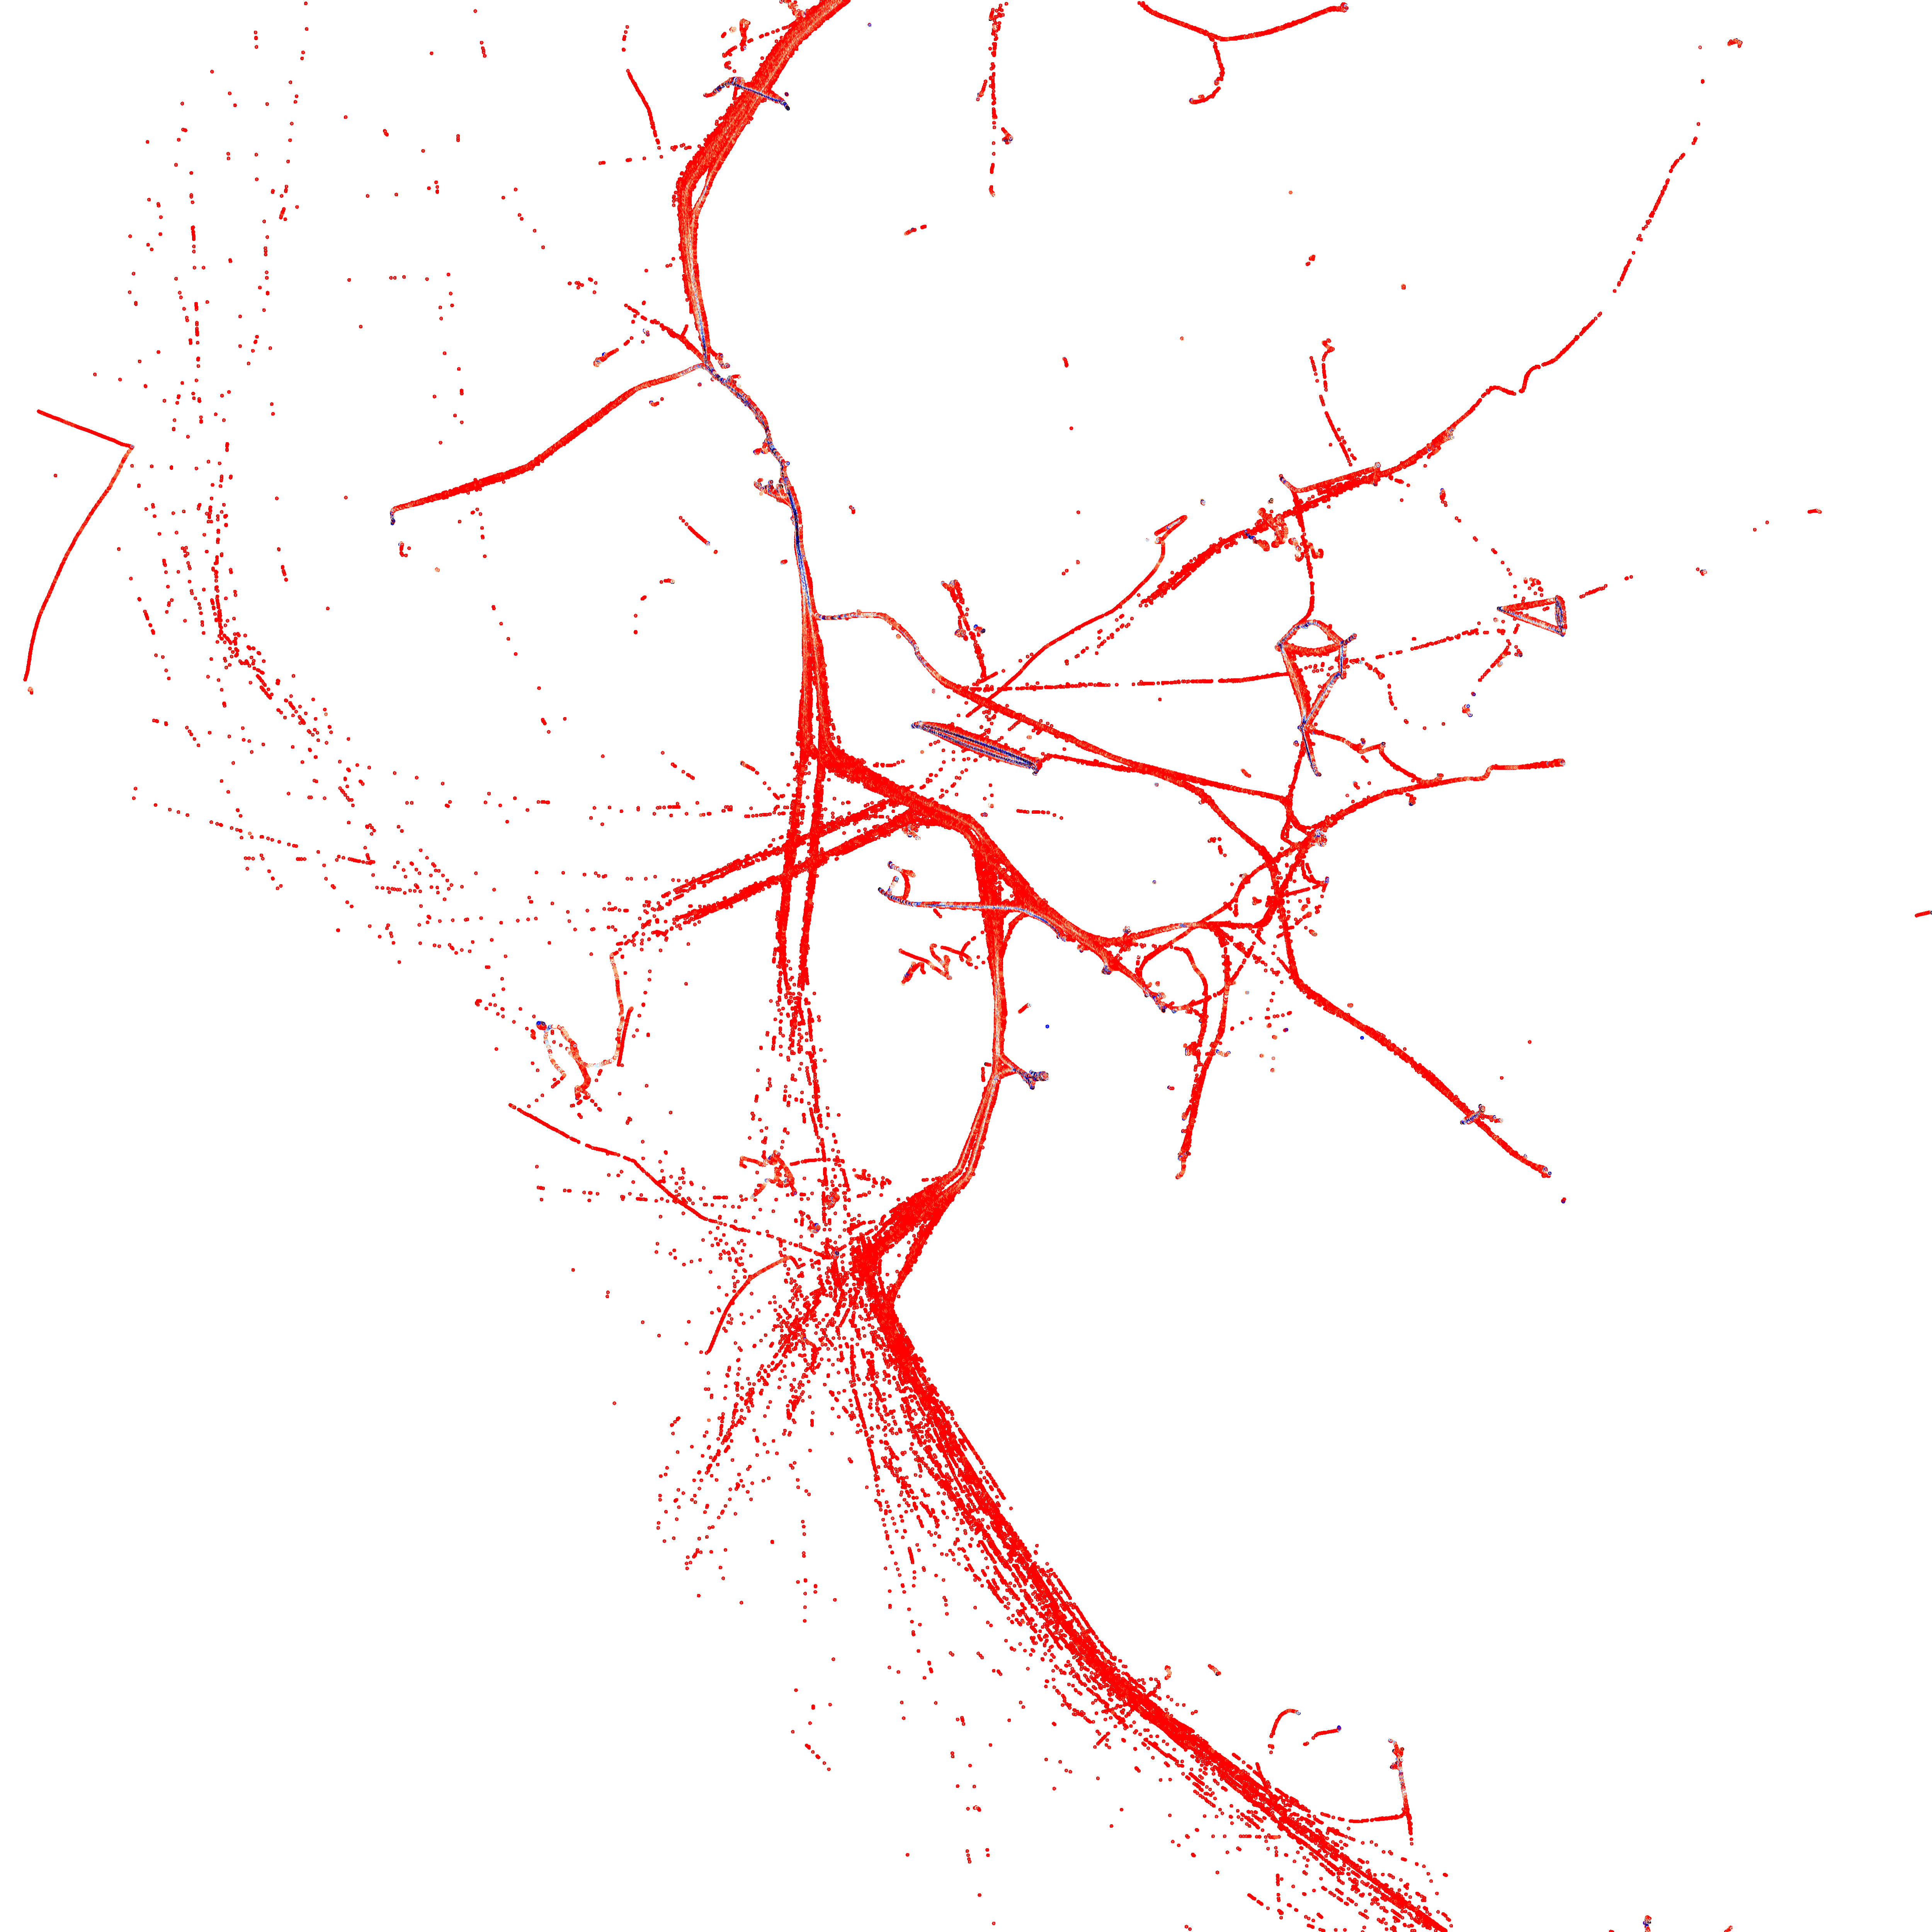

In [7]:
# plotting
detailed_plot = False
if detailed_plot:
    columns = ['geometry', 'mmsi']  # columns to be plotted
    # plot simplified trajectories
    map = network.trajectories.to_traj_gdf()[columns].explore(column='mmsi', name='Simplified trajectories', 
                                                              style_kwds={'weight':1, 'color':'black', 'opacity':0.5}, 
                                                              legend=False)
    # plot significant turning points with their cluster ID
    map = network.significant_points[['clusterID', 'geometry']].explore(m=map, name='all waypoints with cluster ID', legend=False,
                                                                        marker_kwds={'radius':2},
                                                                        style_kwds={'opacity':0.2})
else:
    # plot basemap
    map = folium.Map(location=[59, 5], tiles="OpenStreetMap", zoom_start=8)
    # plot traffic as raster overlay
    map = visualize.traffic_raster_overlay(network.gdf, map)

# plot cluster centroids and their convex hull
cluster_centroids = network.waypoints
cluster_centroids.set_geometry('geometry', inplace=True)
map = cluster_centroids[['clusterID', 'geometry', 'speed']].explore(m=map, name='cluster centroids', legend=False,
                                                                    marker_kwds={'radius':3},
                                                                    style_kwds={'color':'red', 'fillColor':'red', 'fillOpacity':1})
cluster_centroids.set_geometry('convex_hull', inplace=True)
map = cluster_centroids[['clusterID', 'convex_hull']].explore(m=map, name='cluster convex hulls', legend=False,
                                                              style_kwds={'color':'red', 'fillColor':'red', 'fillOpacity':0.2})
folium.LayerControl().add_to(map)

# add a title
title = f'HDBSCAN parameters: min_samples={min_samples}'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   

map.get_root().html.add_child(folium.Element(title_html))

map

In [8]:
network.significant_points

,date_time_utc,mmsi,imo_nr,length,lon,lat,sog,cog,true_heading,nav_status,message_nr,geometry,speed,cog_before,cog_after,clusterID
0,2022-04-08 03:12:48,205209000_0,0,51,5.36673,59.6732,10.6,225.9,225,0,1,POINT (5.36673 59.67320),11.173331,223.265006,223.265006,289
1,2022-04-08 03:28:11,205209000_0,0,51,5.30642,59.6408,10.0,213.3,210,0,3,POINT (5.30642 59.64080),4.265890,223.265006,205.891090,298
2,2022-04-08 03:38:17,205209000_0,0,51,5.28176,59.6151,10.3,210.4,213,0,1,POINT (5.28176 59.61510),5.632842,205.891090,212.033229,-1
3,2022-04-08 04:06:10,205209000_0,0,51,5.19674,59.5462,9.9,179.0,172,0,3,POINT (5.19674 59.54620),4.961274,212.033229,170.000007,-1
4,2022-04-08 04:22:21,205209000_0,0,51,5.21168,59.5032,9.2,177.5,180,0,3,POINT (5.21168 59.50320),4.059219,170.000007,180.000000,351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29958,2022-04-08 21:56:58,636014908_15,9468229,178,5.03448,59.1099,9.7,291.7,293,0,1,POINT (5.03448 59.10990),3.887032,287.403547,292.396376,60
29959,2022-04-08 22:23:48,636014908_15,9468229,178,4.90123,59.1380,9.7,295.1,301,0,1,POINT (4.90123 59.13800),5.876983,292.396376,302.422668,-1
29960,2022-04-08 22:58:50,636014908_15,9468229,178,4.74727,59.1880,9.5,321.7,324,0,1,POINT (4.74727 59.18800),4.774356,302.422668,328.832900,-1
29961,2022-04-08 23:18:59,636014908_15,9468229,178,4.69180,59.2349,10.0,333.3,334,0,1,POINT (4.69180 59.23490),3.864669,328.832900,328.832900,46
